In [1]:
from torch_tmm import Model, BaseLayer, BaseMaterial
from torch_tmm.dispersion import Constant_epsilon, Lorentz, TaucLorentz, Drude, LorentzComplete
import torch
from lmfit import Parameters,Minimizer,minimize
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import elli

In [2]:
Si_subs = pd.read_csv('si_subs.CSV').to_numpy()
Si_Ti_Au = pd.read_csv('Si_Ti2nm_Au7nm.CSV').to_numpy()
Si_Ti_Au_Si1h30min = pd.read_csv('Si_Ti2nm_Au7nm_Si1h30min.CSV').to_numpy()
Si_Ti_Au_Si1h40min = pd.read_csv('Si_Ti2nm_Au7nm_Si1h40min.CSV').to_numpy()
Si_Ti_Au_Si1h50min = pd.read_csv('Si_Ti2nm_Au7nm_Si1h50min.CSV').to_numpy()
Si_Ti_Au_Si2h = pd.read_csv('Si_Ti2nm_Au7nm_Si2h.CSV').to_numpy()

In [3]:
rii_db = elli.db.RII()
Silicon_a = rii_db.get_mat(book='Si', page='Franta')
Silicon_c = rii_db.get_mat(book='Si', page='Franta-25C')
Ti = rii_db.get_mat(book='Ti', page='Rakic-LD')
Au = rii_db.get_mat(book='Au', page='Ciesielski')

In [3]:
dtype=torch.complex64
device=torch.device('cpu')

In [4]:
lam0=np.linspace(2000,20000,361) # in nm for elli model
wavelengths=torch.linspace(2000,20000,361)*1e-9 # in m for Daniele code
angles = torch.linspace(0, 89, 90)

In [6]:
# Experimental data for titanium transmission
model_si = elli.Structure(elli.AIR, [], Silicon_c) # Reference model
data_si = model_si.evaluate(lam0, 0, elli.Solver2x2)

d=2
model=elli.Structure(elli.AIR,[elli.Layer(Ti,d)],Silicon_c)
data_Ti=model.evaluate(lam0, 0, elli.Solver2x2)

T_exp_Ti=data_Ti.T*data_si.T/(1-data_si.R*data_Ti.R)

In [7]:
T_exp_Ti.shape

(361,)

In [8]:
model_a_Si=elli.Structure(elli.AIR,[elli.Layer(Silicon_a,4000),elli.Layer(Au,7),elli.Layer(Ti,2)],Silicon_c)
data_a_Si=model_a_Si.evaluate(lam0, 0, elli.Solver2x2)

T_exp_aSi=data_a_Si.T*data_si.T/(1-data_si.R*data_a_Si.R)
T_exp_aSi.shape

(361,)

In [9]:
# Example of usage Au with Drude model

A_tensor=torch.tensor(1,dtype=dtype,device=device)
A=torch.nn.Parameter(A_tensor)

E0_tensor=torch.tensor(80.92,dtype=dtype,device=device)
E0=torch.nn.Parameter(E0_tensor)

gamma_tensor=torch.tensor(0.25,dtype=dtype,device=device)
gamma=torch.nn.Parameter(gamma_tensor)

d_tensor=torch.tensor(7e-9,dtype=dtype,device=device)
d=torch.nn.Parameter(d_tensor)

env_disp=[Constant_epsilon(torch.nn.Parameter(torch.tensor(1,dtype=dtype,device=device)),dtype=dtype,device=device)]
subs_disp=[Constant_epsilon(torch.nn.Parameter(torch.tensor(3.41**2,dtype=dtype,device=device)),dtype=dtype,device=device)]
Au_disp=[Drude(A=A,E0=E0,C=gamma)]

env_mat=BaseMaterial(env_disp,name='air',dtype=dtype,device=device)
subs_mat=BaseMaterial(subs_disp,name='cSi',dtype=dtype,device=device)
Au_mat=BaseMaterial(Au_disp,name='Ti',dtype=dtype,device=device)

env=BaseLayer(env_mat,thickness=torch.nn.Parameter(torch.tensor(0,dtype=dtype,device=device)),LayerType='env')
subs=BaseLayer(subs_mat,thickness=torch.nn.Parameter(torch.tensor(0,dtype=dtype,device=device)),LayerType='subs')
layer=BaseLayer(Au_mat,thickness=d,LayerType='coh')


ref_model=Model(env,[],subs,dtype,device)
ref_results=ref_model.evaluate(wavelengths,angles)

model=Model(env,[layer],subs,dtype,device)
results=model.evaluate(wavelengths,angles)

Transmission=(results.transmission('p')[:,0]+results.transmission('s')[:,0])/2
Reflection=(results.reflection('p')[:,0]+results.reflection('s')[:,0])/2

ref_Transmission=(ref_results.transmission('p')[:,0]+ref_results.transmission('s')[:,0])/2
ref_Reflection=(ref_results.reflection('p')[:,0]+ref_results.reflection('s')[:,0])/2

T_full=Transmission*ref_Transmission/(1-ref_Reflection*Reflection)

/Users/jaworskj/DataspellProjects/TMM-pythorch/torch_tmm/model.py:167: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Copy.cpp:308.)
  d = layer.thickness.to(self.dtype_real).to(self.device)


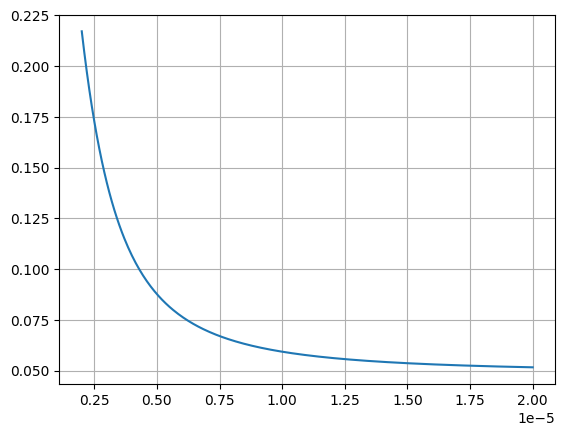

In [10]:
plt.plot(wavelengths,T_full.detach())
plt.grid()

In [11]:
# Fitting parameters of the Ti using Drude model
params=Parameters()

params.add(name='A',value=1,vary=False,min=0,max=1) #Constant to keep consistence with Lorentz reduced model
params.add(name='E0',value=81,vary=True,min=1,max=200) # Resonance energy [eV]
params.add(name='gamma',value=0.014,vary=True,min=0,max=2) # Damping factor [eV]
params.add(name='d',value=2e-9,vary=False,min=0,max=20) # Thickness in [m]

def objective_function_Ti(params,wavelengths,angles,T_exp):

    A_tensor=torch.tensor(params['A'].value,dtype=dtype,device=device)
    A=torch.nn.Parameter(A_tensor)

    E0_tensor=torch.tensor(params['E0'].value,dtype=dtype,device=device)
    E0=torch.nn.Parameter(E0_tensor)

    gamma_tensor=torch.tensor(params['gamma'].value,dtype=dtype,device=device)
    gamma=torch.nn.Parameter(gamma_tensor)

    d_tensor=torch.tensor(params['d'].value,dtype=dtype,device=device)
    d=torch.nn.Parameter(d_tensor)

    # Defining dispersion function
    env_disp=[Constant_epsilon(1+0j,dtype=dtype,device=device)]
    subs_disp=[Constant_epsilon(3.41**2+0j,dtype=dtype,device=device)]
    ti_disp=[Drude(A=A,E0=E0,C=gamma)]

    # Defining materials
    env_mat=BaseMaterial(env_disp,name='air',dtype=dtype,device=device)
    subs_mat=BaseMaterial(subs_disp,name='cSi',dtype=dtype,device=device)
    ti_mat=BaseMaterial(ti_disp,name='Ti',dtype=dtype,device=device)

    # Defining layers
    env=BaseLayer(env_mat,thickness=0,LayerType='env')
    subs=BaseLayer(subs_mat,thickness=0,LayerType='subs')
    layer=BaseLayer(ti_mat,thickness=d_tensor,LayerType='layer')

    # Reference model of the substrate
    ref_model=Model(env,[],subs,dtype,device)
    ref_results=ref_model.evaluate(wavelengths,angles)

    # Actual model of the geometry
    model=Model(env,[layer],subs,dtype,device)
    results=model.evaluate(wavelengths,angles)

    # Transmissions and reflections of geometry
    Transmission=(results.transmission('p')[:,0]+results.transmission('s')[:,0])/2
    Reflection=(results.reflection('p')[:,0]+results.reflection('s')[:,0])/2

    # Transmissions and reflections of substrate
    ref_Transmission=(ref_results.transmission('p')[:,0]+ref_results.transmission('s')[:,0])/2
    ref_Reflection=(ref_results.reflection('p')[:,0]+ref_results.reflection('s')[:,0])/2

    # Corrected Transmission
    T_full=Transmission*ref_Transmission/(1-ref_Reflection*Reflection)

    return T_exp-T_full.detach().numpy()

results=minimize(objective_function_Ti,params,args=(wavelengths,angles,T_exp_Ti))

In [12]:
results

In [13]:
A_drude=results.params['A'].value
E0_drude=results.params['E0'].value
C_drude=results.params['gamma'].value

In [14]:
Ti_disp=[Drude(A=A_drude,E0=E0_drude,C=C_drude,device=device,dtype=dtype)]

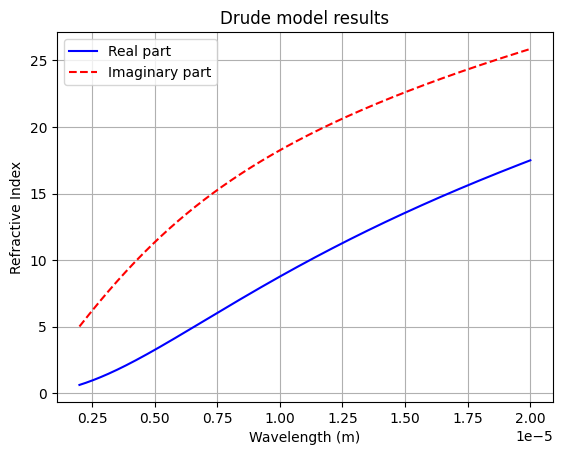

In [15]:
plt.plot(wavelengths, Ti_disp[0].refractive_index(wavelengths).real, linestyle='-', color='b', label='Real part')
plt.plot(wavelengths, Ti_disp[0].refractive_index(wavelengths).imag, linestyle='--', color='r', label='Imaginary part')

# Add labels and legend
plt.xlabel("Wavelength (m)")
plt.ylabel("Refractive Index")
plt.legend()
plt.grid(True)
plt.title('Drude model results')

# Show plot
plt.show()

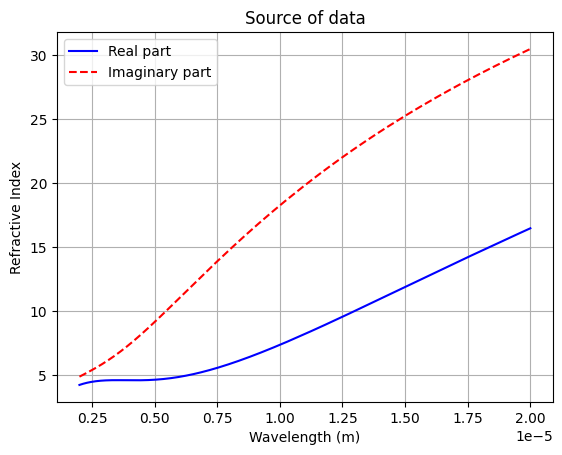

In [16]:
plt.plot(wavelengths, Ti.get_refractive_index(lam0)[:,0,0].real, linestyle='-', color='b', label='Real part')
plt.plot(wavelengths, Ti.get_refractive_index(lam0)[:,0,0].imag, linestyle='--', color='r', label='Imaginary part')

# Add labels and legend
plt.xlabel("Wavelength (m)")
plt.ylabel("Refractive Index")
plt.legend()
plt.title('Source of data')
plt.grid(True)

# Show plot
plt.show()

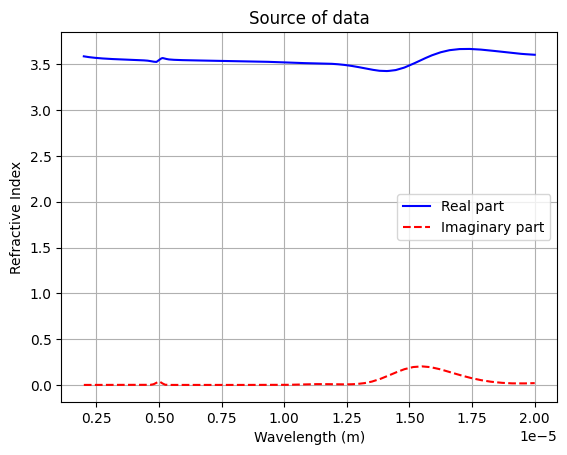

In [22]:
plt.plot(wavelengths, Silicon_a.get_refractive_index(lam0)[:,0,0].real, linestyle='-', color='b', label='Real part')
plt.plot(wavelengths, Silicon_a.get_refractive_index(lam0)[:,0,0].imag, linestyle='--', color='r', label='Imaginary part')

# Add labels and legend
plt.xlabel("Wavelength (m)")
plt.ylabel("Refractive Index")
plt.legend()
plt.title('Source of data')
plt.grid(True)

# Show plot
plt.show()

In [5]:
# Fitting parameters to aSi
T_exp = np.stack([Si_Ti_Au_Si1h30min[:,1], Si_Ti_Au_Si1h40min[:,1], Si_Ti_Au_Si1h50min[:,1], Si_Ti_Au_Si2h[:,1]])
wavelengths=torch.tensor(1e7/Si_Ti_Au[:,0])

params=Parameters()
params.add(name='A',value=0.0015,vary=True,min=0,max=1)
params.add(name='E0',value=1/12.5,vary=True,min=1/15,max=1/10)
params.add(name='gamma',value=0.014,vary=True,min=0.01,max=0.02)
params.add(name='Con',value=12,vary=True,min=9,max=16)
params.add(name='d_1h30min',value=3050e-9,vary=True,min=2500e-9,max=5000e-9)
params.add(name='d_1h40min',value=3450e-9,vary=True,min=2500e-9,max=5000e-9)
params.add(name='d_1h50min',value=3750e-9,vary=True,min=2500e-9,max=5000e-9)
params.add(name='d_2h',value=4065e-9,vary=True,min=2500e-9,max=5000e-9)

def objective_function_aSi(params,wavelengths,angles,T_exp):
    A_tensor=torch.tensor(params['A'].value,dtype=dtype,device=device)
    A=torch.nn.Parameter(A_tensor)

    E0_tensor=torch.tensor(params['E0'].value,dtype=dtype,device=device)
    E0=torch.nn.Parameter(E0_tensor)

    gamma_tensor=torch.tensor(params['gamma'].value,dtype=dtype,device=device)
    gamma=torch.nn.Parameter(gamma_tensor)

    Con_tensor=torch.tensor(params['Con'].value,dtype=dtype,device=device)
    Con=torch.nn.Parameter(Con_tensor)

    d = [params['d_1h30min'], params['d_1h40min'], params['d_1h50min'], params['d_2h']]
    d_tensor=torch.tensor(d,dtype=dtype,device=device)
    d=torch.nn.Parameter(d_tensor)

    # Dispersion model to find

    env_disp=[Constant_epsilon(torch.nn.Parameter(torch.tensor(1,dtype=dtype,device=device)),dtype=dtype,device=device)]
    subs_disp=[Constant_epsilon(torch.nn.Parameter(torch.tensor(3.41**2,dtype=dtype,device=device)),dtype=dtype,device=device)]
    aSi_disp=[LorentzComplete(A=A,E0=E0,C=gamma,Con=Con)]

    aSi_mat=BaseMaterial(aSi_disp,name='aSi',dtype=dtype,device=device)

    # Reference model

    env_mat=BaseMaterial(env_disp,name='air',dtype=dtype,device=device)
    subs_mat=BaseMaterial(subs_disp,name='cSi',dtype=dtype,device=device)

    env=BaseLayer(env_mat,thickness=torch.nn.Parameter(torch.tensor(0,dtype=dtype,device=device)),LayerType='env')
    subs=BaseLayer(subs_mat,thickness=torch.nn.Parameter(torch.tensor(0,dtype=dtype,device=device)),LayerType='subs')

    ref_model=Model(env,[],subs,dtype,device)
    ref_results=ref_model.evaluate(wavelengths,angles)

    ref_Transmission=(ref_results.transmission('p')[:,0]+ref_results.transmission('s')[:,0])/2
    ref_Reflection=(ref_results.reflection('p')[:,0]+ref_results.reflection('s')[:,0])/2

    # Specification of Au and Ti layers

    Au_disp=[Drude(A=torch.nn.Parameter(torch.tensor(1,dtype=dtype,device=device)),E0=torch.nn.Parameter(torch.tensor(80.92,dtype=dtype,device=device)),C=torch.nn.Parameter(torch.tensor(0.25,dtype=dtype,device=device)),dtype=dtype,device=device)]
    Ti_disp=[Drude(A=torch.nn.Parameter(torch.tensor(1,dtype=dtype,device=device)),E0=torch.nn.Parameter(torch.tensor(10.068,dtype=dtype,device=device)),C=torch.nn.Parameter(torch.tensor(0.15458,dtype=dtype,device=device)),device=device,dtype=dtype)]

    Au_mat=BaseMaterial(Au_disp,name='Au',dtype=dtype,device=device)
    Ti_mat=BaseMaterial(Ti_disp,name='Ti',dtype=dtype,device=device)

    Au=BaseLayer(Au_mat,thickness=torch.nn.Parameter(torch.tensor(7e-9,dtype=dtype,device=device)),LayerType='coh')
    Ti=BaseLayer(Ti_mat,thickness=torch.nn.Parameter(torch.tensor(2e-9,dtype=dtype,device=device)),LayerType='coh')

    # modeling geometry
    T = np.zeros(shape=(len(d), len(wavelengths)))
    for i in range(len(d)):
        aSi=BaseLayer(aSi_mat,thickness=d[i],LayerType='coh')
        model=Model(env,[aSi,Au,Ti],subs,dtype,device)

        results=model.evaluate(wavelengths,angles)
        Transmission=(results.transmission('p')[:,0]+results.transmission('s')[:,0])/2
        Reflection=(results.reflection('p')[:,0]+results.reflection('s')[:,0])/2
        T[i,:]=Transmission.detach().numpy()*ref_Transmission.detach().numpy()/(1-ref_Reflection.detach().numpy()*ref_Reflection.detach().numpy())

    return (T-T_exp).reshape([T_exp.shape[0]*T_exp.shape[1]])


results=minimize(objective_function_aSi,params,args=(wavelengths[300:len(wavelengths)-5000],angles,T_exp[:,300:len(wavelengths)-5000]))

/Users/jaworskj/DataspellProjects/TMM-pythorch/torch_tmm/model.py:167: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Copy.cpp:308.)
  d = layer.thickness.to(self.dtype_real).to(self.device)


In [6]:
results

In [7]:
A_lorentz=results.params['A'].value
E0_lorentz=results.params['E0'].value
C_lorentz=results.params['gamma'].value
Con_lorentz=results.params['Con'].value

In [8]:
aSi_disp=[LorentzComplete(A=A_lorentz,E0=E0_lorentz,C=C_lorentz,Con=Con_lorentz,dtype=dtype,device=device)]

In [9]:
wavelengths=torch.linspace(2000,20000,361)*1e-9

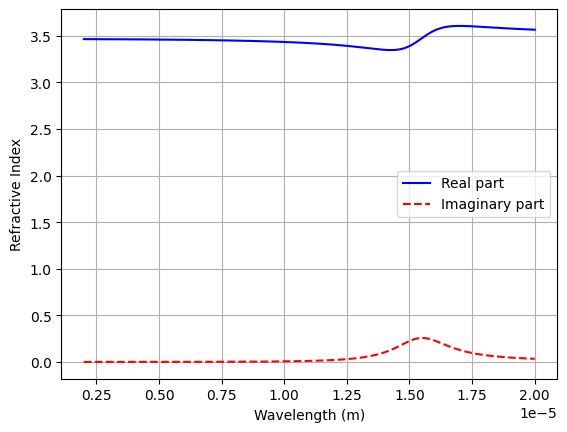

In [10]:
plt.plot(wavelengths, aSi_disp[0].refractive_index(wavelengths).real, linestyle='-', color='b', label='Real part')
plt.plot(wavelengths, aSi_disp[0].refractive_index(wavelengths).imag, linestyle='--', color='r', label='Imaginary part')

# Add labels and legend
plt.xlabel("Wavelength (m)")
plt.ylabel("Refractive Index")
plt.legend()
plt.grid(True)

# Show plot
plt.show()